# Hotel Review Classification

This is a sample dataset which consists of 20,000 reviews and ratings for different hotels and our goal is to examine how travelers are communicating their positive and negative experiences in online platforms for staying in a specific hotel and major objective is what are the attributes that travelers are considering while selecting a hotel. With this manager can understand which elements of their hotel influence more in forming a positive review or improves hotel brand image.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import string
import spacy
from spacy import displacy
import nltk
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, SpatialDropout1D, Flatten, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPool1D, Dense
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from keras.models import load_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, confusion_matrix, classification_report

In [2]:
nlp = spacy.load('en_core_web_lg')

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sailo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
hotel = pd.read_excel('hotel_reviews.xlsx')

In [5]:
hotel.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [6]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


## Null Check

In [7]:
hotel.isna().sum()

Review    0
Rating    0
dtype: int64

## Spaces Check

In [8]:
blanks = []

for i, rv, rt in hotel.itertuples():
    if rv.isspace():
        blanks.append(i)

In [9]:
blanks

[]

In [10]:
hotel['Rating'].value_counts()

Rating
5    9054
4    6039
3    2184
2    1793
1    1421
Name: count, dtype: int64

## Categorical Conversion

In [11]:
hotel['Rating'] = pd.Categorical(hotel['Rating'])

In [12]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Review  20491 non-null  object  
 1   Rating  20491 non-null  category
dtypes: category(1), object(1)
memory usage: 180.4+ KB


## Visualizing POS

In [13]:
displacy.render(nlp(hotel['Review'][1]), style='ent', jupyter=True)

In [14]:
def word_cleaner(text):
    
    text = text.strip()
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    doc = nlp(text)

    lemmatized_words = [token.lemma_ for token in doc]
    
    additional_stopwords = set(['hotel', 'resort', 'day', 'use', 'need', 'think', 'night', 'say', 'look', 'beach', 'stay', 'time', 'people', 'place', 'area', 'room', 'come', 'staff', 'tell'])

    stop_words = set(stopwords.words('english')).union(set(spacy.lang.en.stop_words.STOP_WORDS)).union(additional_stopwords) - {'not'}
    
    lemmatized_words = [word for word in lemmatized_words if word.lower() not in stop_words]

    cleaned_text = ' '.join(lemmatized_words)

    return cleaned_text

Executed the below code cell, Since SpaCy was used for lemmatization it was taking time and hence dumped the dataframe to another excel 

In [15]:
# hotel['cleaned_reviews'] = hotel['Review'].apply(word_cleaner)
# hotel.to_excel('cleaned_hotel.xlsx')

In [16]:
hotel = pd.read_excel('cleaned_hotel.xlsx')

In [17]:
displacy.render(nlp(hotel['cleaned_reviews'][1]), style='ent', jupyter=True)

In [18]:
displacy.render(nlp(hotel['cleaned_reviews'][1]), style='dep', jupyter=True)

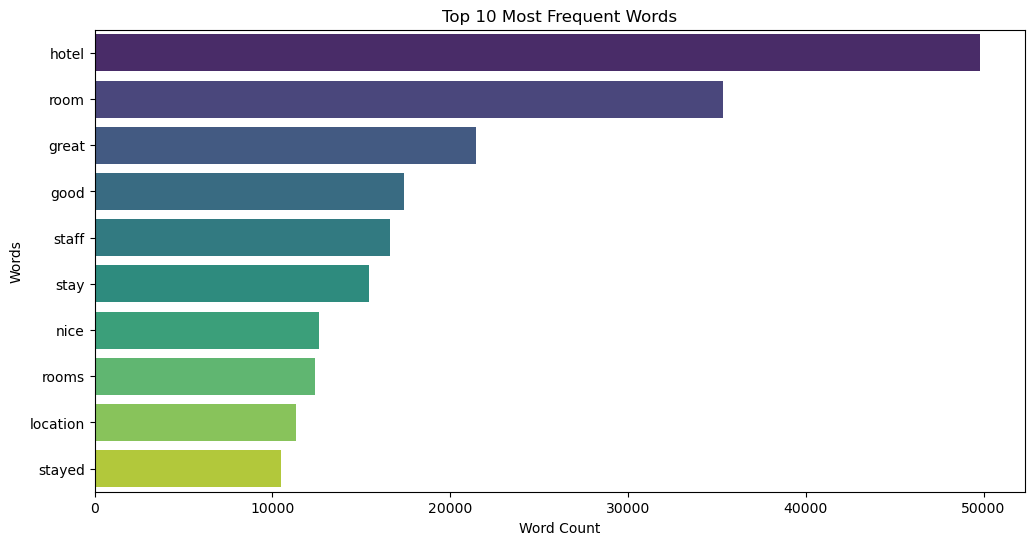

In [19]:
vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(hotel['Review'])
word_count = pd.DataFrame(X.sum(axis=0), columns=vectorizer.get_feature_names_out()).T.sort_values(0, ascending=False)
word_count.columns = ['count']

plt.figure(figsize=(12, 6))
sns.barplot(x='count', y=word_count.index[:10], data=word_count[:10], palette='viridis')
plt.title('Top 10 Most Frequent Words')
plt.xlabel('Word Count')
plt.ylabel('Words')
plt.show()

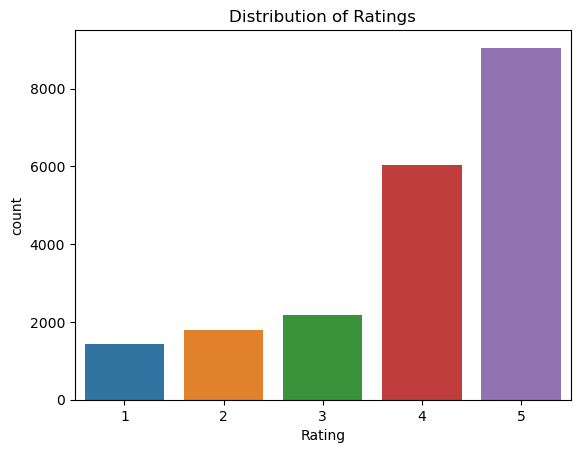

In [20]:
sns.countplot(x='Rating', data=hotel)
plt.title('Distribution of Ratings')
plt.show()

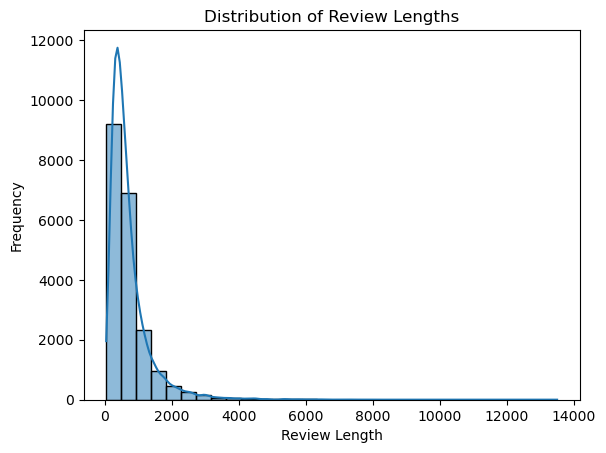

In [21]:
hotel['Review_Length'] = hotel['Review'].apply(len)
sns.histplot(hotel['Review_Length'], bins=30, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

In [22]:
max_seq_len = hotel['Review_Length'].max()

C:\Users\sailo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


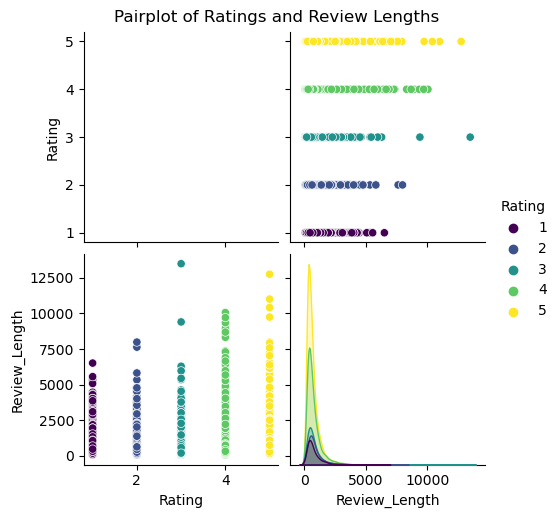

In [23]:
sns.pairplot(hotel, vars=['Rating', 'Review_Length'], hue='Rating', palette='viridis')
plt.suptitle('Pairplot of Ratings and Review Lengths', y=1.02)
plt.show()

## Sentiment Analysis - Polarity Scores

In [24]:
sid = SentimentIntensityAnalyzer()
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [25]:
hotel['Polarity_Scores'] = hotel['cleaned_reviews'].apply(lambda review: sid.polarity_scores(review)['compound'])

In [26]:
hotel.head(15)

,Unnamed: 0,Review,Rating,cleaned_reviews,Review_Length,Polarity_Scores
0,0,nice hotel expensive parking got good deal sta...,4,nice expensive parking good deal anniversary a...,593,0.9747
1,1,ok nothing special charge diamond member hilto...,2,ok special charge diamond member hilton decide...,1689,0.9879
2,2,nice rooms not 4* experience hotel monaco seat...,3,nice not 4 experience monaco seattle good not ...,1427,0.9924
3,3,"unique, great stay, wonderful time hotel monac...",5,unique great wonderful monaco location excelle...,600,0.9918
4,4,"great stay great stay, went seahawk game aweso...",5,great great seahawk game awesome downfall view...,1281,0.9864
5,5,love monaco staff husband stayed hotel crazy w...,5,love monaco husband crazy weekend attend memor...,1002,0.9824
6,6,"cozy stay rainy city, husband spent 7 nights m...",5,cozy rainy city husband spend 7 monaco early j...,748,0.9924
7,7,"excellent staff, housekeeping quality hotel ch...",4,excellent housekeeping quality chock feel home...,597,0.9628
8,8,"hotel stayed hotel monaco cruise, rooms genero...",5,monaco cruise generous decorate uniquely remod...,419,0.9618
9,9,excellent stayed hotel monaco past w/e delight...,5,excellent monaco past delight reception friend...,271,0.9756


In [27]:
hotel[hotel['Rating'] < 3].iloc[0,1:3]

Review    ok nothing special charge diamond member hilto...
Rating                                                    2
Name: 1, dtype: object

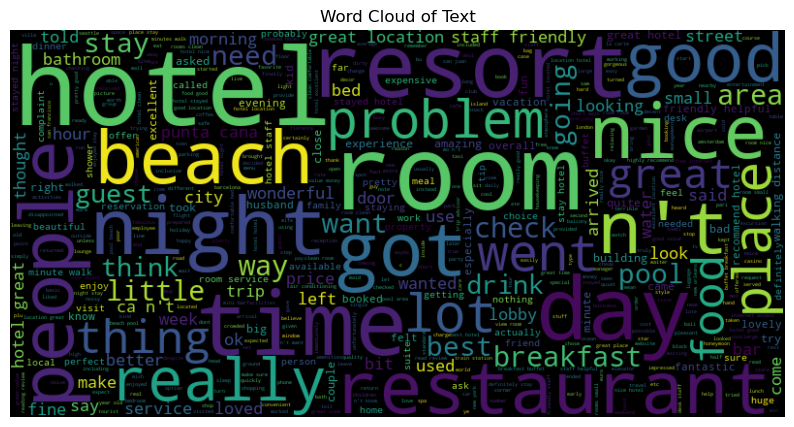

In [28]:
all_text = ' '.join(hotel['Review'])
wordcloud = WordCloud(max_words=500, width=800, height=400, random_state=42, max_font_size=110).generate(all_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud of Text')
plt.show()

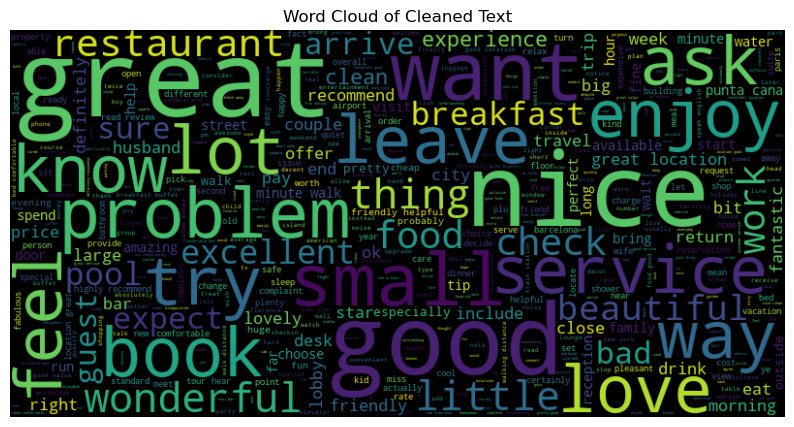

In [29]:
all_text = ' '.join(hotel['cleaned_reviews'])
wordcloud = WordCloud(max_words=500, width=800, height=400, random_state=42, max_font_size=110).generate(all_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud of Cleaned Text')
plt.show()

In [30]:
hotel['Polarity_Scores'].max()

0.9999

In [31]:
hotel['Polarity_Scores'].min()

-0.9967

In [32]:
def sentiment(label):
    if label < 0:
        return "Negative"
    elif label >= 0:
        return "Positive"

In [33]:
hotel['Sentiment'] = hotel['Polarity_Scores'].apply(sentiment)

In [34]:
hotel.head()

,Unnamed: 0,Review,Rating,cleaned_reviews,Review_Length,Polarity_Scores,Sentiment
0,0,nice hotel expensive parking got good deal sta...,4,nice expensive parking good deal anniversary a...,593,0.9747,Positive
1,1,ok nothing special charge diamond member hilto...,2,ok special charge diamond member hilton decide...,1689,0.9879,Positive
2,2,nice rooms not 4* experience hotel monaco seat...,3,nice not 4 experience monaco seattle good not ...,1427,0.9924,Positive
3,3,"unique, great stay, wonderful time hotel monac...",5,unique great wonderful monaco location excelle...,600,0.9918,Positive
4,4,"great stay great stay, went seahawk game aweso...",5,great great seahawk game awesome downfall view...,1281,0.9864,Positive


In [35]:
hotel.drop(columns=['Unnamed: 0', 'Review', 'Review_Length'], inplace=True)

In [36]:
hotel.head()

,Rating,cleaned_reviews,Polarity_Scores,Sentiment
0,4,nice expensive parking good deal anniversary a...,0.9747,Positive
1,2,ok special charge diamond member hilton decide...,0.9879,Positive
2,3,nice not 4 experience monaco seattle good not ...,0.9924,Positive
3,5,unique great wonderful monaco location excelle...,0.9918,Positive
4,5,great great seahawk game awesome downfall view...,0.9864,Positive


In [37]:
hotel['Rating'][hotel['Polarity_Scores'] > 0].value_counts()

Rating
5    9006
4    5972
3    2016
2    1321
1     640
Name: count, dtype: int64

In [38]:
hotel['Rating'][hotel['Polarity_Scores'] < 0].value_counts()

Rating
1    778
2    470
3    165
4     66
5     46
Name: count, dtype: int64

In [39]:
pos_revs = hotel[hotel.Sentiment == 'Positive']
pos_revs = pos_revs.sort_values(['Polarity_Scores'], ascending=False)
pos_revs.head()

,Rating,cleaned_reviews,Polarity_Scores,Sentiment
18917,5,ocean blue excellent boyfriend mid20 ocean blu...,0.9999,Positive
2967,4,bravo bavaro knew not fivestar incredibly reas...,0.9998,Positive
17777,5,fantastic return trip firstly apology length r...,0.9998,Positive
14116,5,not wait till year 2nd 16th 2008we lofts week ...,0.9998,Positive
14183,4,awesomebeautiful vacation little boonie gran m...,0.9998,Positive


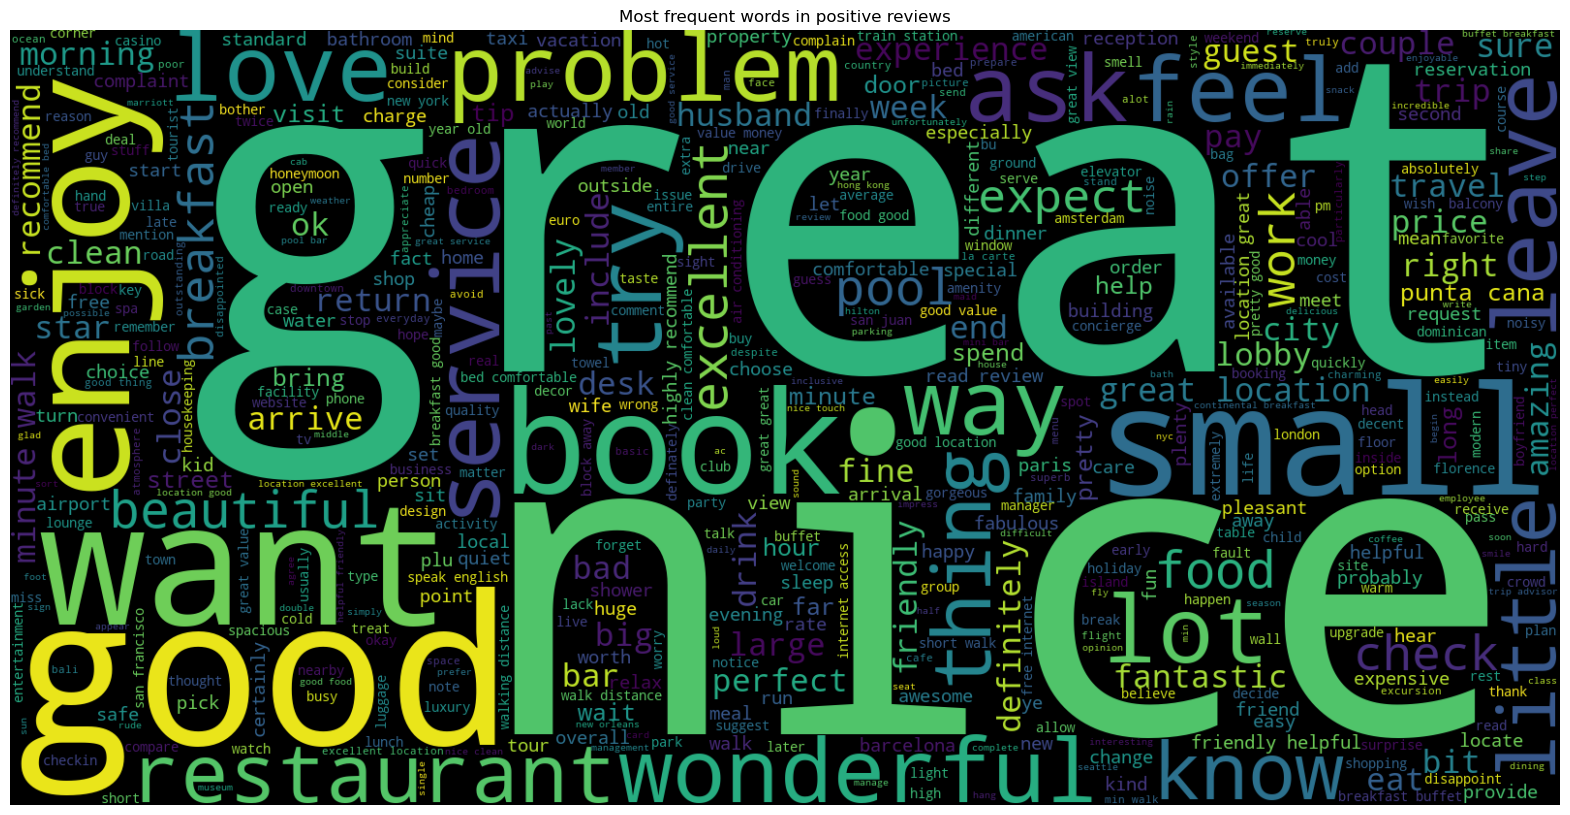

In [40]:
text = ' '.join([word for word in pos_revs['cleaned_reviews']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500,width=1600,height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive reviews')
plt.show()

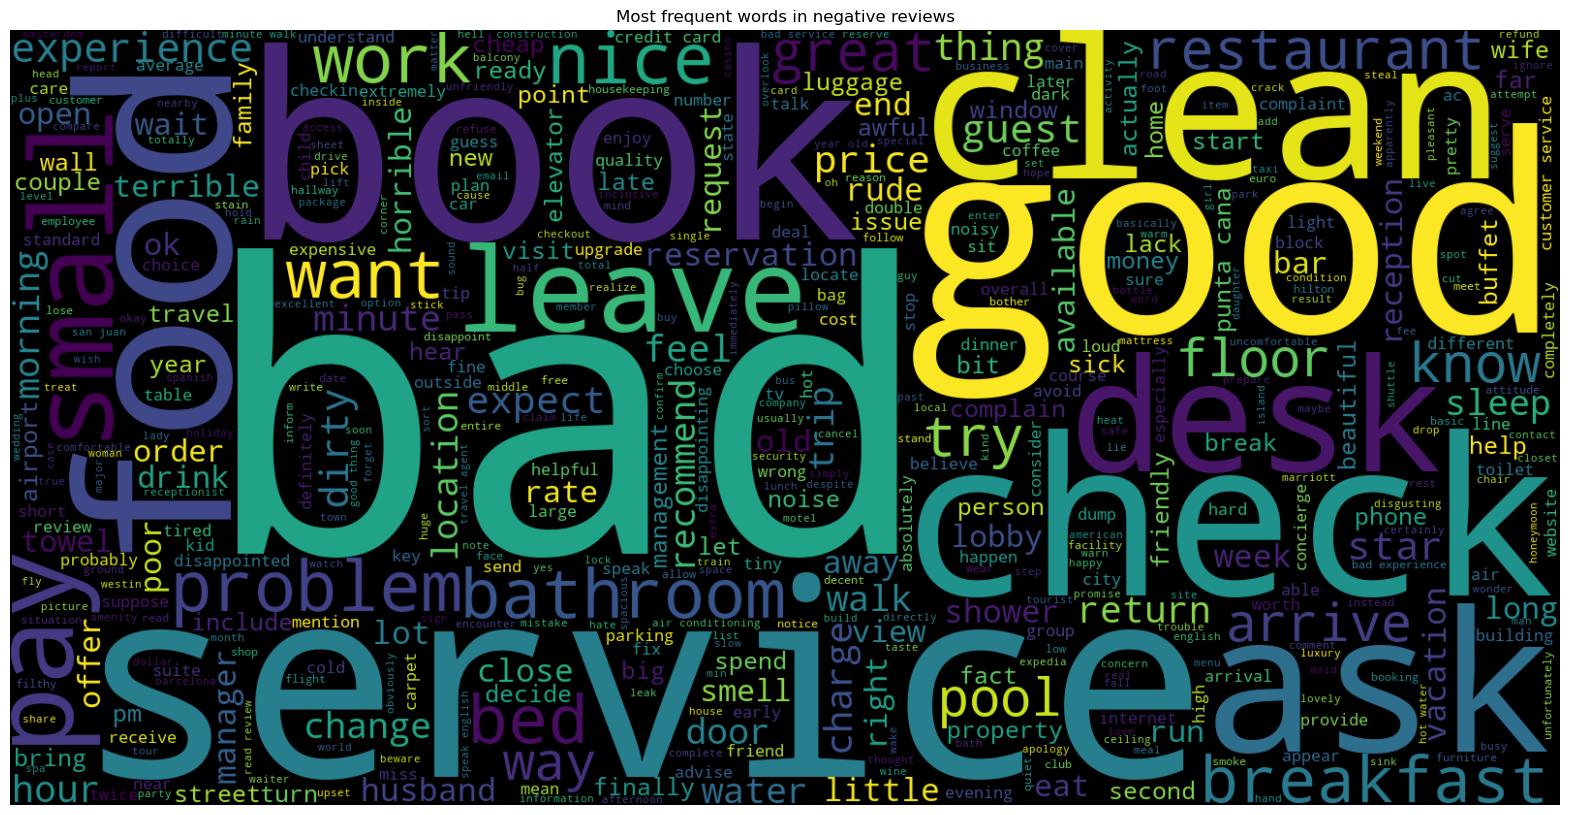

In [41]:
neg_revs = hotel[hotel.Sentiment == 'Negative']
neg_revs = neg_revs.sort_values(['Polarity_Scores'], ascending=False)
neg_revs.head()

text = ' '.join([word for word in neg_revs['cleaned_reviews']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500,width=1600,height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative reviews')
plt.show()

## Vectorization

In [42]:
X = hotel['cleaned_reviews']
y = hotel['Sentiment']

vectorizer = TfidfVectorizer()

X_vector = vectorizer.fit_transform(X)

oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X_vector, y)
undersample = RandomUnderSampler(sampling_strategy='majority')
X_combined, y_combined = undersample.fit_resample(X_over, y_over)

X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.3, random_state=12)

## Logistic Regression

In [43]:
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [44]:
predictions = logreg_model.predict(X_test)

In [45]:
logreg_model.score(X_test , y_test)

0.9600175746924429

In [46]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

    Negative       0.93      0.99      0.96      5661
    Positive       0.99      0.93      0.96      5719

    accuracy                           0.96     11380
   macro avg       0.96      0.96      0.96     11380
weighted avg       0.96      0.96      0.96     11380



In [47]:
confusion_matrix(y_test, predictions)

array([[5622,   39],
       [ 416, 5303]], dtype=int64)

In [48]:
lg_ac = accuracy_score(y_test, predictions)

## SVC

In [49]:
clf_svm = SVC(kernel='linear', random_state=42)

clf_svm.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [50]:
clf_svm.score(X_test , y_test) 

0.9796133567662566

In [51]:
predictions = clf_svm.predict(X_test)

In [52]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

    Negative       0.96      1.00      0.98      5661
    Positive       1.00      0.96      0.98      5719

    accuracy                           0.98     11380
   macro avg       0.98      0.98      0.98     11380
weighted avg       0.98      0.98      0.98     11380



In [53]:
confusion_matrix(y_test, predictions)

array([[5661,    0],
       [ 232, 5487]], dtype=int64)

In [54]:
sv_ac = accuracy_score(y_test, predictions)

In [55]:
clf_svm.predict(vectorizer.transform(["Hotel is bad, but people are very good and service is good"]))

array(['Positive'], dtype=object)

## Random Forest

In [56]:
clf_rf = RandomForestClassifier(random_state=42, max_depth=10)

In [57]:
clf_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [58]:
rf_score = clf_rf.score(X_test, y_test)
print("Random Forest Classifier Score:", rf_score)

Random Forest Classifier Score: 0.920298769771529


In [59]:
predictions_rf = clf_rf.predict(X_test)

In [60]:
print(classification_report(y_test, predictions_rf))

              precision    recall  f1-score   support

    Negative       0.89      0.95      0.92      5661
    Positive       0.95      0.89      0.92      5719

    accuracy                           0.92     11380
   macro avg       0.92      0.92      0.92     11380
weighted avg       0.92      0.92      0.92     11380



In [61]:
print(confusion_matrix(y_test, predictions_rf))

[[5393  268]
 [ 639 5080]]


In [62]:
rf_ac=accuracy_score(y_test, predictions_rf)
rf_ac

0.920298769771529

In [63]:
rf_cv_scores = cross_val_score(clf_rf, X_train, y_train, cv=5)

## Gradient Boost

In [64]:
clf_gb = GradientBoostingClassifier(random_state=42)

In [65]:
clf_gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [66]:
gb_score = clf_gb.score(X_test, y_test)
print("Gradient Boosting Classifier Score:", gb_score)

Gradient Boosting Classifier Score: 0.9116871704745168


In [67]:
predictions_gb = clf_gb.predict(X_test)

In [68]:
print(classification_report(y_test, predictions_gb))

              precision    recall  f1-score   support

    Negative       0.88      0.95      0.91      5661
    Positive       0.94      0.88      0.91      5719

    accuracy                           0.91     11380
   macro avg       0.91      0.91      0.91     11380
weighted avg       0.91      0.91      0.91     11380



In [69]:
print(confusion_matrix(y_test, predictions_gb))

[[5354  307]
 [ 698 5021]]


In [70]:
gb_ac=accuracy_score(y_test, predictions_gb)
gb_ac

0.9116871704745168

## Adaboost

In [71]:
adaboost_clf = AdaBoostClassifier(
    n_estimators=50,
    learning_rate=1.0,
    algorithm='SAMME.R')

In [72]:
adaboost_clf.fit(X_train, y_train)

AdaBoostClassifier()

In [73]:
ab_score = adaboost_clf.score(X_test, y_test)
print("Adaboost Classifier Score:", ab_score)

Adaboost Classifier Score: 0.8835676625659051


In [74]:
adaboost_pred = adaboost_clf.predict(X_test)

In [75]:
print(classification_report(y_test, adaboost_pred))

              precision    recall  f1-score   support

    Negative       0.88      0.88      0.88      5661
    Positive       0.89      0.88      0.88      5719

    accuracy                           0.88     11380
   macro avg       0.88      0.88      0.88     11380
weighted avg       0.88      0.88      0.88     11380



In [76]:
print(confusion_matrix(y_test, adaboost_pred))

[[5005  656]
 [ 669 5050]]


In [77]:
ab_ac=accuracy_score(y_test, adaboost_pred)
ab_ac

0.8835676625659051

## CNN

In [78]:
max_words = 2500
embed_dim = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(hotel.cleaned_reviews.values)
word_index = tokenizer.word_index
X_cnn = tokenizer.texts_to_sequences(hotel.cleaned_reviews.values)

In [79]:
X_cnn = pad_sequences(X_cnn, maxlen=max_seq_len)
y_cnn = pd.get_dummies(hotel['Sentiment']).values

X_cnn_train, X_cnn_test, y_cnn_train, y_cnn_test = train_test_split(X_cnn, y_cnn, test_size=0.2, random_state=42)

In [80]:
X_cnn_train.shape

(16392, 13501)

In [81]:
y_cnn_train.shape

(16392, 2)

In [82]:
# cnn = Sequential()
# cnn.add(Embedding(max_words, embed_dim, input_length=X_cnn_train.shape[1]))
# cnn.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
# cnn.add(GlobalMaxPool1D())
# cnn.add(Dense(64, activation='relu'))
# cnn.add(Dense(2, activation='softmax'))
# cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

# history = cnn.fit(X_cnn_train, y_cnn_train, epochs=5, batch_size=64, validation_split=0.1)

In [83]:
#cnn.save("trained_cnn_model.h5")

In [84]:
cnn = load_model("trained_cnn_model.h5")

In [85]:
cnn_ac = cnn.evaluate(X_cnn_test, y_cnn_test)
print(f'Loss: {cnn_ac[0]:.3f}\nAccuracy: {cnn_ac[1]:.3f}')

129/129 [==============================] - 59s 448ms/step - loss: 0.2623 - accuracy: 0.9475
Loss: 0.262
Accuracy: 0.948


## Naive Bayes

In [86]:
clf_nb = MultinomialNB()
clf_nb.fit(X_train, y_train)

MultinomialNB()

In [87]:
nb_score = clf_nb.score(X_test, y_test)
print("Naive Bayes Classifier Score:", nb_score)

Naive Bayes Classifier Score: 0.9311072056239016


In [88]:
predictions_nb = clf_nb.predict(X_test)

In [89]:
print(classification_report(y_test, predictions_nb))

              precision    recall  f1-score   support

    Negative       0.90      0.96      0.93      5661
    Positive       0.96      0.90      0.93      5719

    accuracy                           0.93     11380
   macro avg       0.93      0.93      0.93     11380
weighted avg       0.93      0.93      0.93     11380



In [90]:
print(confusion_matrix(y_test, predictions_nb))

[[5450  211]
 [ 573 5146]]


In [91]:
nb_ac=accuracy_score(y_test, predictions_nb)
nb_ac

0.9311072056239016

In [92]:
nb_cv_scores = cross_val_score(clf_nb, X_train, y_train, cv=5)

## Decision Tree - Gini

In [93]:
cart_gini = DecisionTreeClassifier(criterion='gini', max_depth=39)

In [94]:
cart_gini_cv_scores = cross_val_score(cart_gini, X_train, y_train, cv=5)

In [95]:
cart_gini.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=39)

In [96]:
pred_gini = cart_gini.predict(X_test)
cartg_ac = accuracy_score(y_test, pred_gini)
print("Decision Tree Classifier Accuracy:", cartg_ac)

Decision Tree Classifier Accuracy: 0.9528119507908611


In [97]:
print(classification_report(y_test, pred_gini))

              precision    recall  f1-score   support

    Negative       0.91      1.00      0.95      5661
    Positive       1.00      0.91      0.95      5719

    accuracy                           0.95     11380
   macro avg       0.96      0.95      0.95     11380
weighted avg       0.96      0.95      0.95     11380



In [98]:
print("Cross-Validation Scores:", cart_gini_cv_scores)
print("Mean Cross-Validation Score:", np.mean(cart_gini_cv_scores))

Cross-Validation Scores: [0.951045   0.95142158 0.9480226  0.94821092 0.94708098]
Mean Cross-Validation Score: 0.9491562159480678


## Decision Tree - Entropy

In [99]:
cart_ent = DecisionTreeClassifier(criterion='entropy', max_depth=39)

In [100]:
cart_ent_cv_scores = cross_val_score(cart_ent, X_train, y_train, cv=5)

In [101]:
cart_ent.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=39)

In [102]:
pred_ent = cart_ent.predict(X_test)
carte_ac = accuracy_score(y_test, pred_ent)
print("Decision Tree Classifier Accuracy:", carte_ac)

Decision Tree Classifier Accuracy: 0.9575571177504394


In [103]:
print(classification_report(y_test, pred_ent))

              precision    recall  f1-score   support

    Negative       0.92      1.00      0.96      5661
    Positive       1.00      0.92      0.96      5719

    accuracy                           0.96     11380
   macro avg       0.96      0.96      0.96     11380
weighted avg       0.96      0.96      0.96     11380



In [104]:
print("Cross-Validation Scores:", cart_ent_cv_scores)
print("Mean Cross-Validation Score:", np.mean(cart_ent_cv_scores))

Cross-Validation Scores: [0.95744681 0.95518735 0.95423729 0.95386064 0.95178908]
Mean Cross-Validation Score: 0.9545042322351968


## KNN

In [105]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)

predictions_knn = knn_classifier.predict(X_test)

knn_ac = accuracy_score(y_test, predictions_knn)
print(f"Accuracy: {knn_ac}")

classification_rep = classification_report(y_test, predictions_knn)
print("Classification Report:\n", classification_rep)

Accuracy: 0.9231985940246046
Classification Report:
               precision    recall  f1-score   support

    Negative       0.87      1.00      0.93      5661
    Positive       1.00      0.85      0.92      5719

    accuracy                           0.92     11380
   macro avg       0.93      0.92      0.92     11380
weighted avg       0.93      0.92      0.92     11380



In [106]:
print(confusion_matrix(y_test, predictions_nb))

[[5450  211]
 [ 573 5146]]


In [107]:
modelEvaldf = pd.DataFrame(columns=['Model', 'ACCURACY'])
modelEvaldf.loc[len(modelEvaldf.index)] = ['Logistic Regression', lg_ac]
modelEvaldf.loc[len(modelEvaldf.index)] = ['SVC', sv_ac]
modelEvaldf.loc[len(modelEvaldf.index)] = ['Random Forest classifier', rf_ac]
modelEvaldf.loc[len(modelEvaldf.index)] = ['Gradient Boost classifier', gb_ac]
modelEvaldf.loc[len(modelEvaldf.index)] = ['AdaBoost classifier', ab_ac]
modelEvaldf.loc[len(modelEvaldf.index)] = ['CNN', round(cnn_ac[1], 3)]
modelEvaldf.loc[len(modelEvaldf.index)] = ['Naive Bayes classifier', nb_ac]
modelEvaldf.loc[len(modelEvaldf.index)] = ['Random Forest classifier K-Fold', np.mean(rf_cv_scores)]
modelEvaldf.loc[len(modelEvaldf.index)] = ['Naive Bayes classifier K-Fold', np.mean(nb_cv_scores)]
modelEvaldf.loc[len(modelEvaldf.index)] = ['Decision Tree Gini', cartg_ac]
modelEvaldf.loc[len(modelEvaldf.index)] = ['Decision Tree Gini K-Fold', np.mean(cart_gini_cv_scores)]
modelEvaldf.loc[len(modelEvaldf.index)] = ['Decision Tree Entropy', carte_ac]
modelEvaldf.loc[len(modelEvaldf.index)] = ['Decision Tree Entropy K-Fold', np.mean(cart_ent_cv_scores)]
modelEvaldf.loc[len(modelEvaldf.index)] = ['KNN', knn_ac]

In [108]:
modelEvaldf

,Model,ACCURACY
0,Logistic Regression,0.960018
1,SVC,0.979613
2,Random Forest classifier,0.920299
3,Gradient Boost classifier,0.911687
4,AdaBoost classifier,0.883568
5,CNN,0.948000
6,Naive Bayes classifier,0.931107
7,Random Forest classifier K-Fold,0.915185
8,Naive Bayes classifier K-Fold,0.928292
9,Decision Tree Gini,0.952812
